In [1]:
#import thư viện
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import os


C:\Users\pnthv\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
# Đường dẫn dataset
train_dir = "../dataset_splits/train"
validation_dir = "../dataset_splits/validation"
test_dir = "../dataset_splits/test"

# Hyperparameters
image_size = 150
batch_size = 32
epochs = 1          #đổi số epoch để chạy nhiều hơn dùm nha
learning_rate = 1e-3
num_classes = 6
color_mode = 'rgb'  
channels = 3  

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Lưu class names
class_names = list(train_generator.class_indices.keys())

steps_per_epoch = int(np.ceil(train_generator.samples / batch_size))
validation_steps = int(np.ceil(validation_generator.samples / batch_size))
test_steps = int(np.ceil(test_generator.samples / batch_size))

print(f"\nClasses: {list(train_generator.class_indices.keys())}")
print(f"  Mẫu Training:   {train_generator.samples:>5} → {steps_per_epoch:>3} steps")
print(f"  Mẫu Validation: {validation_generator.samples:>5} → {validation_steps:>3} steps")
print(f"  Mẫu Test:       {test_generator.samples:>5} → {test_steps:>3} steps")
print(f"  Input shape:        ({image_size}, {image_size}, {channels})")

Found 7245 images belonging to 6 classes.
Found 1355 images belonging to 6 classes.
Found 448 images belonging to 6 classes.

Classes: ['0', '1', '2', '3', '4', '5']
  Mẫu Training:    7245 → 227 steps
  Mẫu Validation:  1355 →  43 steps
  Mẫu Test:         448 →  14 steps
  Color mode:         rgb
  Input shape:        (150, 150, 3)


In [10]:
#Xây dựng model
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(image_size, image_size, 3), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    
    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', name='conv4'),
    layers.MaxPooling2D((2, 2), name='pool4'),
    
    # Fully Connected Layers
    layers.Flatten(name='flatten'),
    layers.Dropout(0.6, name='dropout'),
    layers.Dense(256, activation='relu', 
                kernel_regularizer=regularizers.l2(0.002), name='fc1'),
    layers.Dense(num_classes, activation='softmax', name='output')
])

# Hiển thị kiến trúc model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,601,478 (13.74 MB)

 Trainable params: 3,601,478 (13.74 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [12]:
callbacks = [
    ModelCheckpoint(
        './saved_model/tomato_rgb_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Giảm learning rate khi plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Lưu model cuối cùng
model.save('./saved_model/tomato_rgb_final.h5')

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.5021 - auc: 0.8068 - loss: 1.5615 - precision: 0.7013 - recall: 0.3093
Epoch 1: val_accuracy improved from None to 0.81624, saving model to ./saved_model/tomato_rgb_best.h5



Epoch 1: finished saving model to ./saved_model/tomato_rgb_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 129s 555ms/step - accuracy: 0.6592 - auc: 0.9155 - loss: 1.1065 - precision: 0.8023 - recall: 0.5299 - val_accuracy: 0.8162 - val_auc: 0.9745 - val_loss: 0.6683 - val_precision: 0.8490 - val_recall: 0.7845 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [14]:
print("Đánh giá trên tập testing")
print("=" * 70)

# Evaluate model với số steps chính xác
test_results = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

# Lấy predictions trên toàn bộ tập test
test_generator.reset()
y_pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# LẤY ĐÚNG SỐ LƯỢNG TRUE LABELS
y_true = test_generator.classes[:test_generator.samples]

# KIỂM TRA
print(f" Tổng mẫu test:    {test_generator.samples}")
print(f" Dự đoán được tạo: {len(y_pred)}")
print(f" Nhãn đúng được thu thập: {len(y_true)}")

# Đảm bảo cắt đúng số lượng
y_pred = y_pred[:test_generator.samples]
y_true = y_true[:test_generator.samples]

# Tính các metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 70)
print("Metric trên tập test")
print("=" * 70)
print(f"Test Loss:      {test_results[0]:.4f}")
print(f"Test Accuracy:  {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall:    {test_recall*100:.2f}%")
print(f"Test F1-Score:  {test_f1*100:.2f}%")
print(f"Test AUC:       {test_results[4]:.4f}")

Đánh giá trên tập testing
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.8259 - auc: 0.9718 - loss: 0.6888 - precision: 0.8565 - recall: 0.7991
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
 Tổng mẫu test:    448
 Dự đoán được tạo: 448
 Nhãn đúng được thu thập: 448

Metric trên tập test
Test Loss:      0.6888
Test Accuracy:  82.59%
Test Precision: 86.21%
Test Recall:    82.59%
Test F1-Score:  80.55%
Test AUC:       0.9718


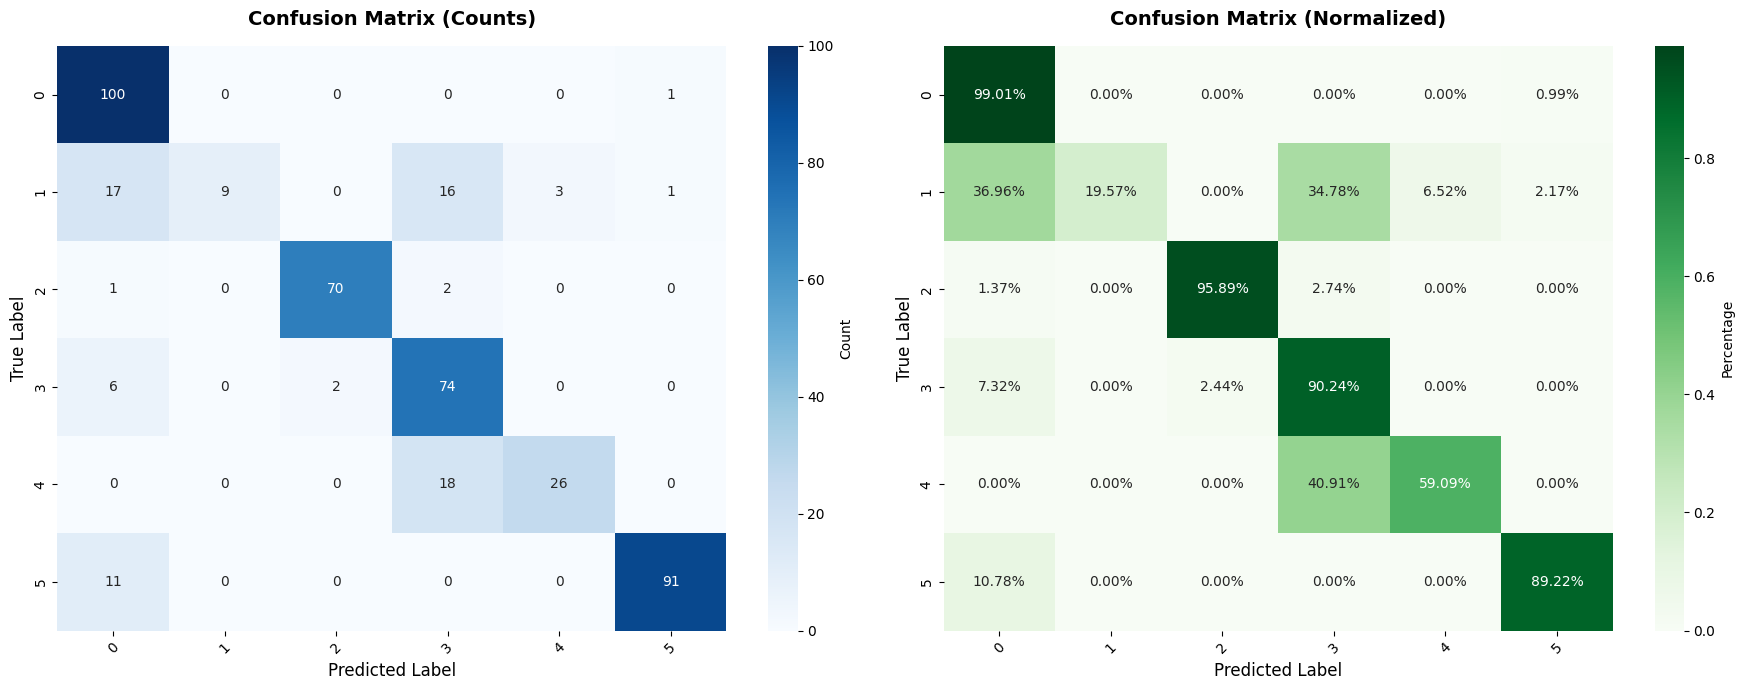

In [15]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Vẽ confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Tính accuracy cho từng class
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Confusion Matrix (Count)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Confusion Matrix (Normalized)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Percentage'},
                ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return cm

cm = plot_confusion_matrix(y_true, y_pred, class_names)

In [16]:
print("Classification report")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Tạo DataFrame từ classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nBảng metrics theo từng lớp:")
print(df_report.to_string())

Classification report
              precision    recall  f1-score   support

           0     0.7407    0.9901    0.8475       101
           1     1.0000    0.1957    0.3273        46
           2     0.9722    0.9589    0.9655        73
           3     0.6727    0.9024    0.7708        82
           4     0.8966    0.5909    0.7123        44
           5     0.9785    0.8922    0.9333       102

    accuracy                         0.8259       448
   macro avg     0.8768    0.7550    0.7595       448
weighted avg     0.8621    0.8259    0.8055       448


Bảng metrics theo từng lớp:
              precision    recall  f1-score     support
0              0.740741  0.990099  0.847458  101.000000
1              1.000000  0.195652  0.327273   46.000000
2              0.972222  0.958904  0.965517   73.000000
3              0.672727  0.902439  0.770833   82.000000
4              0.896552  0.590909  0.712329   44.000000
5              0.978495  0.892157  0.933333  102.000000
accuracy      

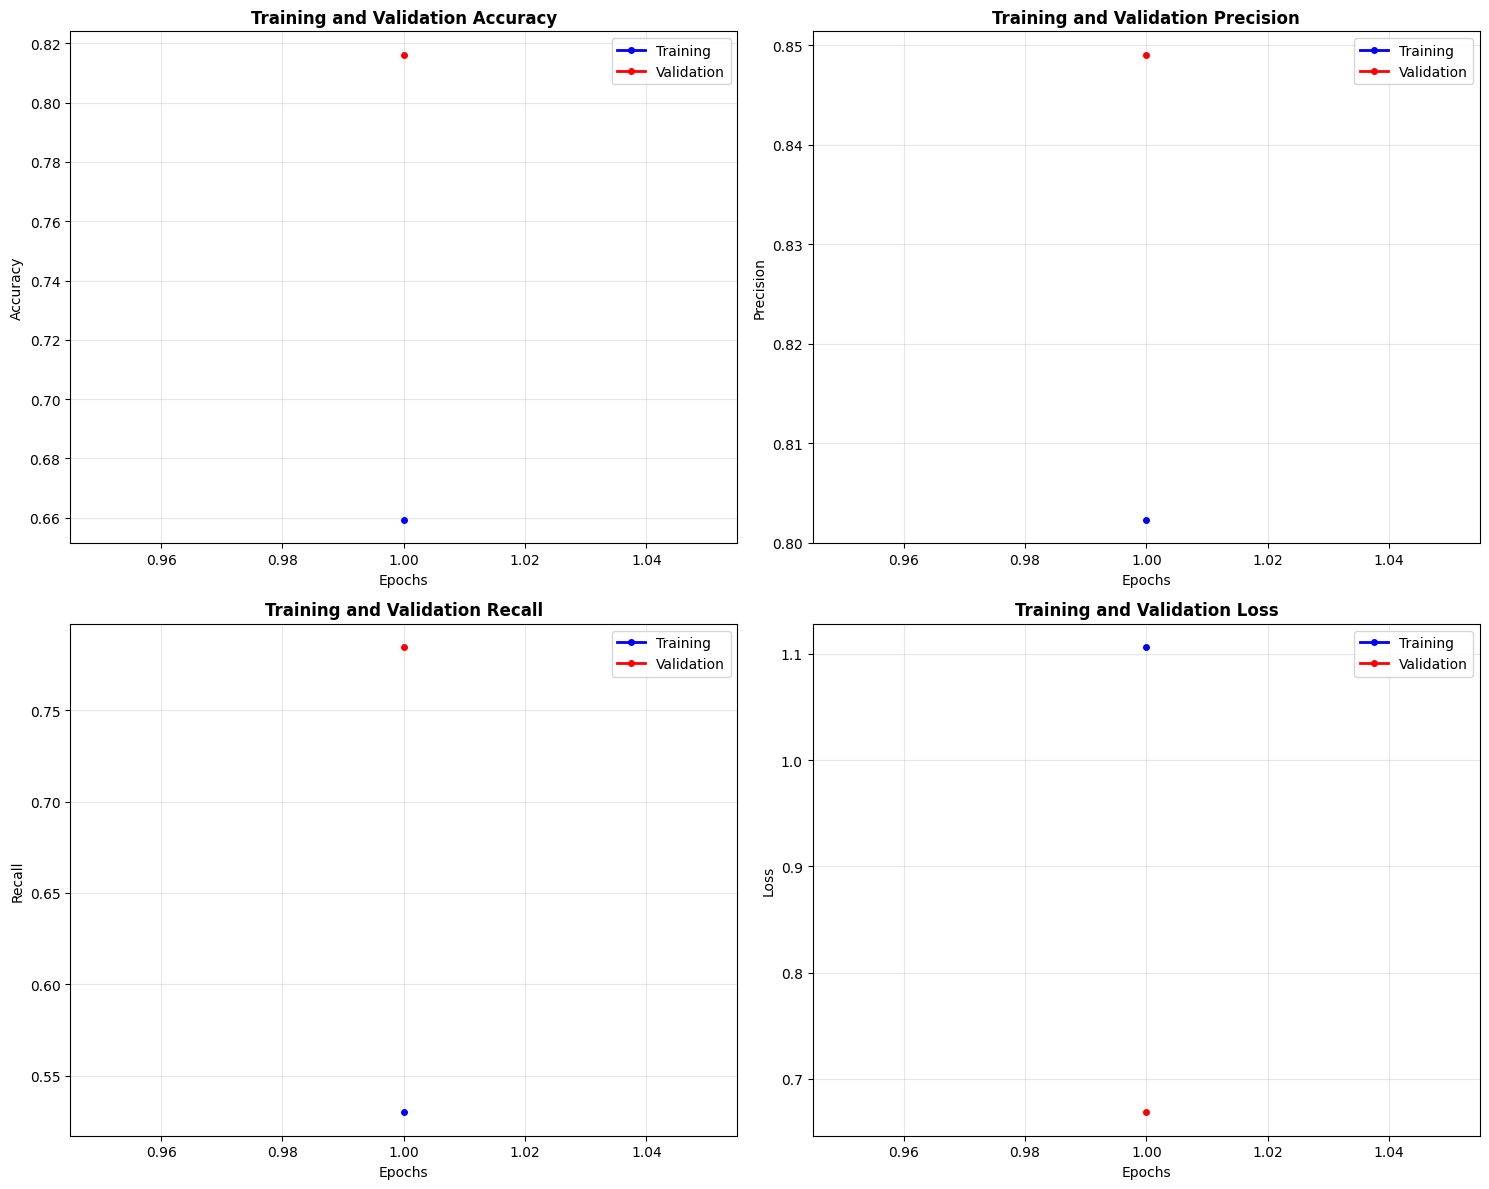


Kết quả training chi tiết
Best Training Accuracy:    65.92%
Best Validation Accuracy:  81.62%
Best Training Precision:   80.23%
Best Validation Precision: 84.90%
Best Training Recall:      52.99%
Best Validation Recall:    78.45%
Final Training Loss:       1.1065
Final Validation Loss:     0.6683


In [18]:
def plot_training_history(history):
    """Vẽ biểu đồ quá trình training với nhiều metrics"""
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'loss']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        if metric == 'loss':
            train_metric = history.history['loss']
            val_metric = history.history['val_loss']
            title = 'Training and Validation Loss'
            ylabel = 'Loss'
        else:
            train_metric = history.history[metric]
            val_metric = history.history[f'val_{metric}']
            title = f'Training and Validation {metric.capitalize()}'
            ylabel = metric.capitalize()
        
        ax.plot(epochs_range, train_metric, 'bo-', label=f'Training', linewidth=2, markersize=4)
        ax.plot(epochs_range, val_metric, 'ro-', label=f'Validation', linewidth=2, markersize=4)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Epochs', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # In thông tin chi tiết
    print("\n" + "=" * 70)
    print("Kết quả training chi tiết")
    print("=" * 70)
    print(f"Best Training Accuracy:    {max(history.history['accuracy'])*100:.2f}%")
    print(f"Best Validation Accuracy:  {max(history.history['val_accuracy'])*100:.2f}%")
    print(f"Best Training Precision:   {max(history.history['precision'])*100:.2f}%")
    print(f"Best Validation Precision: {max(history.history['val_precision'])*100:.2f}%")
    print(f"Best Training Recall:      {max(history.history['recall'])*100:.2f}%")
    print(f"Best Validation Recall:    {max(history.history['val_recall'])*100:.2f}%")
    print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")

# Vẽ biểu đồ
plot_training_history(history)

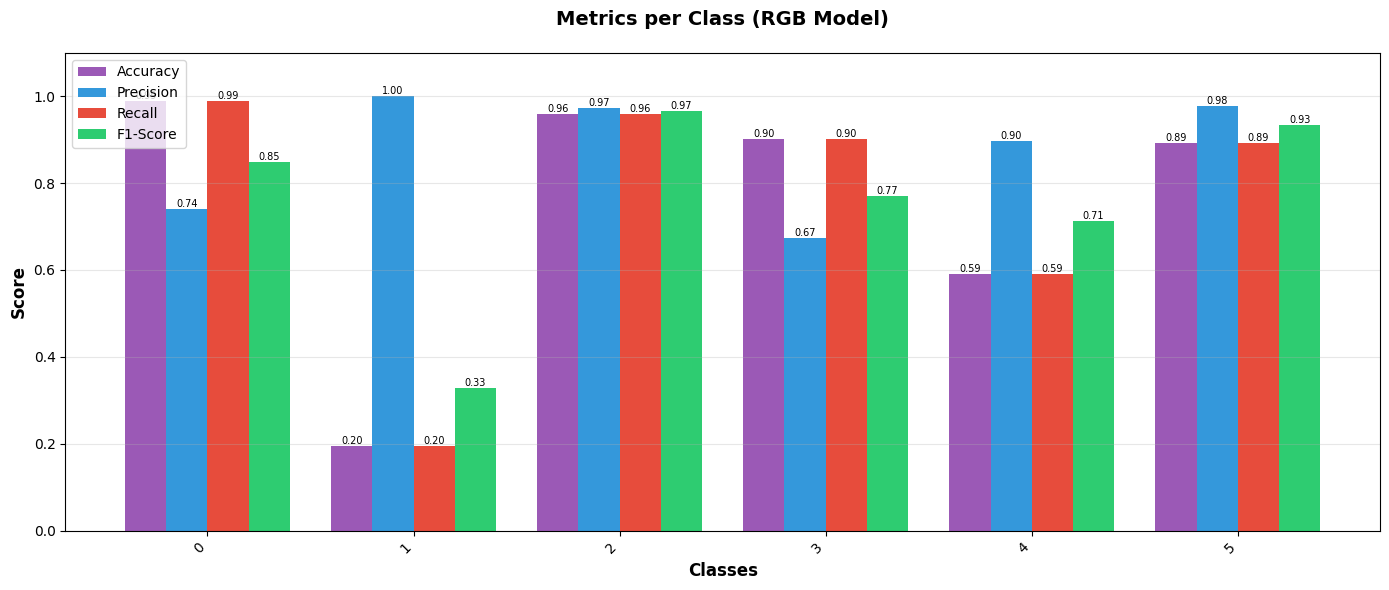


Metrics cho từng lớp
Class  Accuracy  Precision   Recall  F1-Score  Support
    0  0.990099   0.740741 0.990099  0.847458      101
    1  0.195652   1.000000 0.195652  0.327273       46
    2  0.958904   0.972222 0.958904  0.965517       73
    3  0.902439   0.672727 0.902439  0.770833       82
    4  0.590909   0.896552 0.590909  0.712329       44
    5  0.892157   0.978495 0.892157  0.933333      102


In [19]:
def plot_metrics_per_class(y_true, y_pred, class_names):
    """Vẽ biểu đồ metrics cho từng class"""
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Tính accuracy per class từ confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    
    x = np.arange(len(class_names))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars1 = ax.bar(x - 1.5*width, accuracy_per_class, width, label='Accuracy', color='#9b59b6')
    bars2 = ax.bar(x - 0.5*width, precision_per_class, width, label='Precision', color='#3498db')
    bars3 = ax.bar(x + 0.5*width, recall_per_class, width, label='Recall', color='#e74c3c')
    bars4 = ax.bar(x + 1.5*width, f1_per_class, width, label='F1-Score', color='#2ecc71')
    
    ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Metrics per Class (RGB Model)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    # Thêm giá trị trên các cột
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # In bảng chi tiết
    print("\n" + "=" * 70)
    print("Metrics cho từng lớp")
    print("=" * 70)
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': accuracy_per_class,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class,
        'Support': cm.sum(axis=1)
    })
    print(metrics_df.to_string(index=False))
    
    return metrics_df

metrics_df = plot_metrics_per_class(y_true, y_pred, class_names)


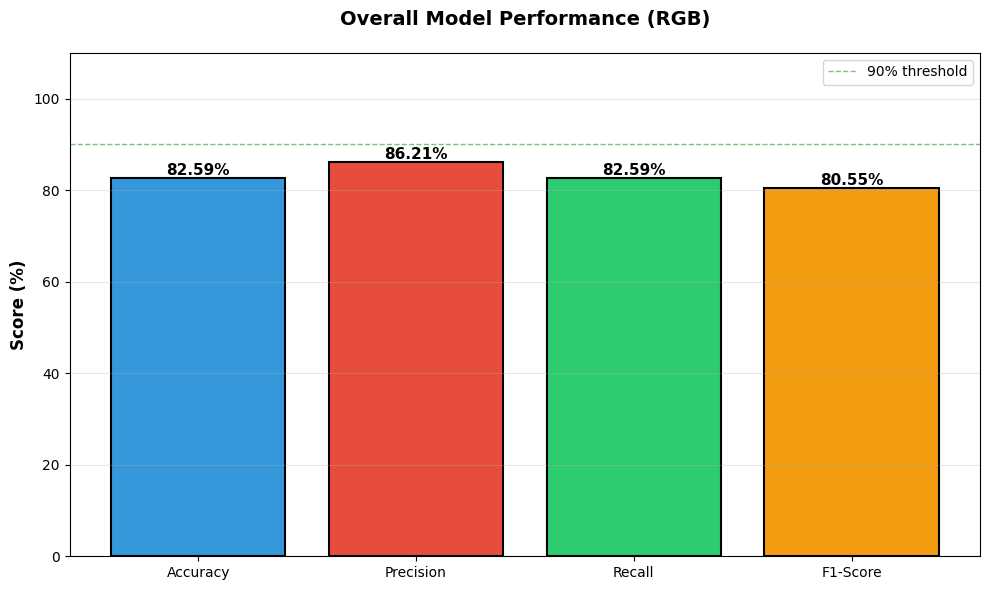

In [20]:
def plot_model_comparison():
    """So sánh các metrics tổng quan"""
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [
        test_results[1] * 100,
        test_precision * 100,
        test_recall * 100,
        test_f1 * 100
    ]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics_names, metrics_values, 
                   color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
                   edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Model Performance (RGB)', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim([0, 110])
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=90, color='green', linestyle='--', linewidth=1, alpha=0.5, label='90% threshold')
    ax.legend()
    
    # Thêm giá trị trên các cột
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}%',
               ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_model_comparison()


In [22]:
print("Tổng kết")
print(f"""
\n=================Thông Tin Model===================\n
- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: {image_size}x{image_size}x{channels} (RGB)
- Số lớp phân loại: {num_classes}
- Tổng số parameters: {model.count_params():,}

\n=================Thông Tin Tập Dữ Liệu===================\n
- Training samples:   {train_generator.samples:>5} ({steps_per_epoch} steps/epoch)
- Validation samples: {validation_generator.samples:>5} ({validation_steps} steps)
- Test samples:       {test_generator.samples:>5} ({test_steps} steps)
- Classes: {', '.join(class_names)}


\n=================Thông Tin Hyperparameters===================\n
- Learning rate (initial): {learning_rate}
- Batch size: {batch_size}
- Epochs trained: {len(history.history['loss'])} / {epochs}
- Optimizer: Adam
- Loss function: Categorical Crossentropy

\n=================Thông Tin Regularization===================\n
- Dropout: 0.6
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5

\n=================Kết Quả Training & Validation===================\n
Training (Final):
  - Accuracy:    {history.history['accuracy'][-1]*100:>6.2f}%
  - Precision:   {history.history['precision'][-1]*100:>6.2f}%
  - Recall:      {history.history['recall'][-1]*100:>6.2f}%
  - Loss:        {history.history['loss'][-1]:>6.4f}

Validation (Final):
  - Accuracy:    {history.history['val_accuracy'][-1]*100:>6.2f}%
  - Precision:   {history.history['val_precision'][-1]*100:>6.2f}%
  - Recall:      {history.history['val_recall'][-1]*100:>6.2f}%
  - Loss:        {history.history['val_loss'][-1]:>6.4f}

Best Validation Metrics:
  - Best Accuracy:  {max(history.history['val_accuracy'])*100:.2f}% (epoch {np.argmax(history.history['val_accuracy'])+1})
  - Best Precision: {max(history.history['val_precision'])*100:.2f}%
  - Best Recall:    {max(history.history['val_recall'])*100:.2f}%

\n=================Kết Quả Trên Tập Test===================\n
- Test Accuracy:  {test_results[1]*100:>6.2f}%
- Test Precision: {test_precision*100:>6.2f}%
- Test Recall:    {test_recall*100:>6.2f}%
- Test F1-Score:  {test_f1*100:>6.2f}%
- Test AUC:       {test_results[4]:>6.4f}
- Test Loss:      {test_results[0]:>6.4f}
""")

Tổng kết


=================Thông Tin Model===================

- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: 150x150x3 (RGB)
- Số lớp phân loại: 6
- Tổng số parameters: 3,601,478


=================Thông Tin Tập Dữ Liệu===================

- Training samples:    7245 (227 steps/epoch)
- Validation samples:  1355 (43 steps)
- Test samples:         448 (14 steps)
- Classes: 0, 1, 2, 3, 4, 5



=================Thông Tin Hyperparameters===================

- Learning rate (initial): 0.001
- Batch size: 32
- Epochs trained: 1 / 1
- Optimizer: Adam
- Loss function: Categorical Crossentropy


=================Thông Tin Regularization===================

- Dropout: 0.6
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5


=================Kết Quả Training & Validation===================

Training (Final):
  - Accuracy:     65.92%
  - Precision:    80.23%
  - Recall:       52.99%
  - Loss:        1.1065

Validation (Final):
  - A

In [ ]:
!git remote -v

origin	https://github.com/bbelal/PlantVillage-Project.git (fetch)
origin	https://github.com/bbelal/PlantVillage-Project.git (push)


In [ ]:
!git remote set-url origin https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git


In [ ]:
!git remote -v


origin	https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git (fetch)
origin	https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git (push)


In [ ]:
!git status -sb

## pntv
 M ../.ipynb_checkpoints/create_dataset_small-checkpoint.ipynb
A  convNet_1.ipynb
 D ../figures/inspiration.jpeg
?? saved_model/


In [ ]:
!git push -u origin pntv

branch 'pntv' set up to track 'origin/pntv'.


remote: 
remote: Create a pull request for 'pntv' on GitHub by visiting:        
remote:      https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning/pull/new/pntv        
remote: 
To https://github.com/tano-dev/Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning.git
 * [new branch]      pntv -> pntv
